In [26]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from preprocess import Preprocessing, PATH
from evaluation import get_results, get_cross_validation_scores, plot_parameter_sensitivity
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import matplotlib.pylab as plt
from scipy.stats import randint

In [27]:
	
# df to save random search times
index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)

              precision    recall  f1-score   support

           1       0.95      0.81      0.88        78
           2       0.83      0.96      0.89        75
           3       1.00      1.00      1.00        42

    accuracy                           0.91       195
   macro avg       0.93      0.92      0.92       195
weighted avg       0.92      0.91      0.91       195



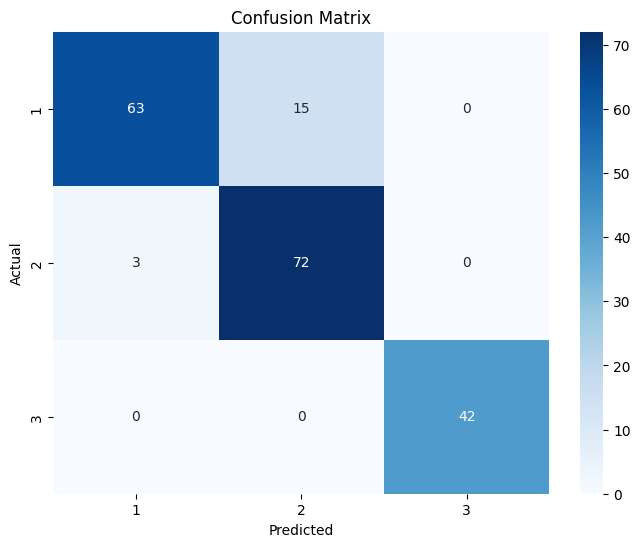

In [28]:
pp = Preprocessing()
target_names = ['1', '2', '3']
# random forest doesn't require scaling
X_train, X_test, y_train, y_test = pp.pipeline(PATH, split=True, scale=True, encode_labels=False)
# Train a baseline random forest
rf_base = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_test)

get_results(y_test, y_pred_base, target_names)

In [29]:
get_cross_validation_scores(rf_base, X_train, y_train )

10-Fold CV Scores: [0.8970696  0.88343347 0.8967033  0.87001425 0.92288188 0.92288188
 0.89509036 0.82862745 0.88100217 0.84283653]
Average f1_weighted Score: 0.8841
Standard Deviation: 0.0291


Test different values for number of estimator

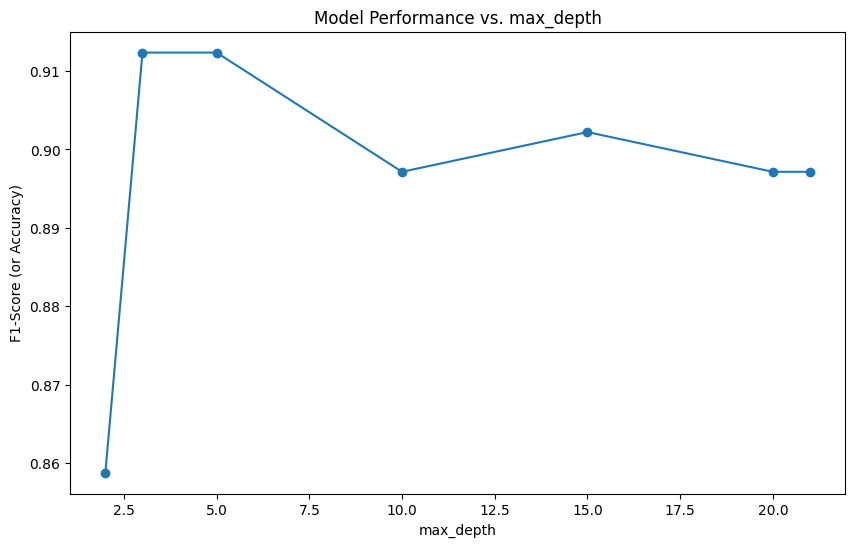

In [30]:
# Checking for the importance of tree depth
# The comparison metric will be F1 score
param_range = [2, 3, 5, 10, 15, 20, None] 
f1_scores = []

for depth in param_range:
    rf_exp = RandomForestClassifier(
        n_estimators=100, 
        max_depth=depth,  
        random_state=42
    )
    rf_exp.fit(X_train, y_train)
    
    report = classification_report(
        y_test, 
        rf_exp.predict(X_test), 
        output_dict=True
    )
    f1_scores.append(report['weighted avg']['f1-score'])



plot_params = [p if p is not None else max(p for p in param_range if p is not None) + 1 for p in param_range]
plot_parameter_sensitivity(
    param_values=plot_params, 
    scores=f1_scores, 
    param_name="max_depth"
)

In [31]:
model_name = 'rf_scaled'

rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
# The parameters to optimize
param_distributions = {
    'n_estimators': randint(100, 500),
    
    'max_depth': randint(3, 20),
    
    'min_samples_leaf': randint(1, 10),

    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

# The final model
final_model = random_search.best_estimator_

Best parameters found: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 6, 'n_estimators': 485}
Best F1-score: 0.8898


              precision    recall  f1-score   support

           1       0.97      0.81      0.88        78
           2       0.83      0.97      0.90        75
           3       1.00      1.00      1.00        42

    accuracy                           0.91       195
   macro avg       0.93      0.93      0.93       195
weighted avg       0.92      0.91      0.91       195



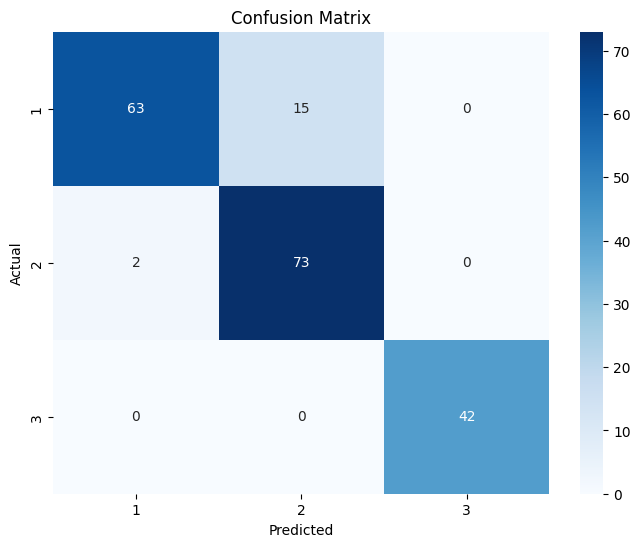

In [32]:
y_pred = final_model.predict(X_test)
get_results(y_test, y_pred, target_names)

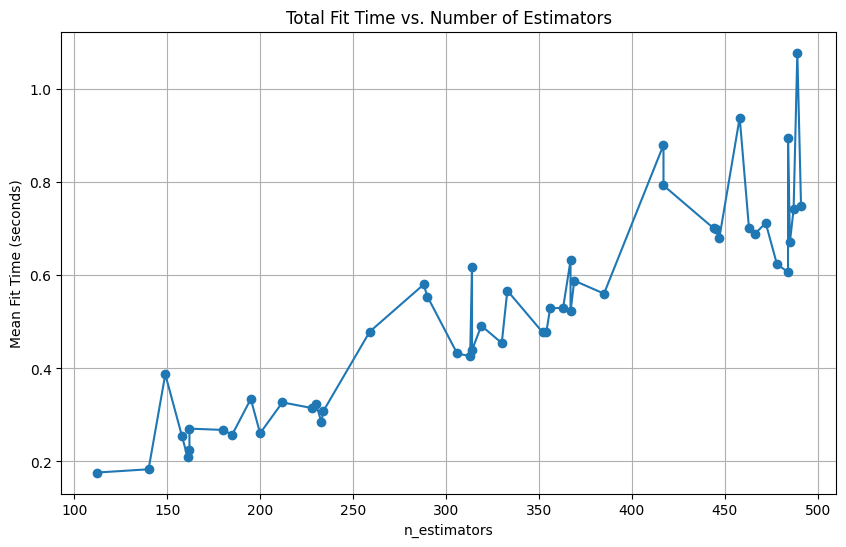

In [33]:
# Plot fit mean times regarding number of estimators
results = random_search.cv_results_
df_results = pd.DataFrame({
    'n_estimators' : results['param_n_estimators'],
    'mean_fit_time': results['mean_fit_time']
})

df_results = df_results.sort_values(by = 'n_estimators')

plt.figure(figsize = (10,6))
plt.plot(df_results['n_estimators'], df_results['mean_fit_time'], marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Fit Time (seconds)')
plt.title('Total Fit Time vs. Number of Estimators')
plt.grid(True)
plt.show()

## Unscaled data

In [34]:
pp = Preprocessing()
target_names = ['1', '2', '3']
# random forest doesn't require scaling
X_train, X_test, y_train, y_test = pp.pipeline(PATH, split=True, scale=False, encode_labels=False)

              precision    recall  f1-score   support

           1       0.97      0.81      0.88        78
           2       0.83      0.97      0.90        75
           3       1.00      1.00      1.00        42

    accuracy                           0.91       195
   macro avg       0.93      0.93      0.93       195
weighted avg       0.92      0.91      0.91       195



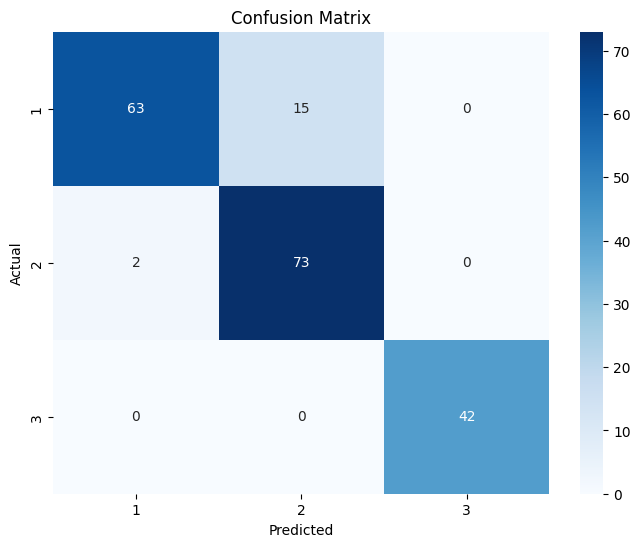

In [35]:
# Train a baseline random forest
rf_base = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_test)

get_results(y_test, y_pred_base, target_names)

In [36]:
get_cross_validation_scores(rf_base, X_train, y_train )

10-Fold CV Scores: [0.8970696  0.88343347 0.8967033  0.87001425 0.92288188 0.93560406
 0.89509036 0.82862745 0.88100217 0.85543449]
Average f1_weighted Score: 0.8866
Standard Deviation: 0.0294


In [37]:
model_name = 'rf_unscaled'

rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced',
    oob_score=True 
)

# Parameters to optimize
param_distributions = {
    'n_estimators': randint(100, 500),
    
    'max_depth': randint(3, 20),
    
    'min_samples_leaf': randint(1, 10),

    'max_features': ['sqrt', 'log2']
}


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 6, 'n_estimators': 485}
Best F1-score: 0.8898


              precision    recall  f1-score   support

           1       0.97      0.81      0.88        78
           2       0.83      0.97      0.90        75
           3       1.00      1.00      1.00        42

    accuracy                           0.91       195
   macro avg       0.93      0.93      0.93       195
weighted avg       0.92      0.91      0.91       195



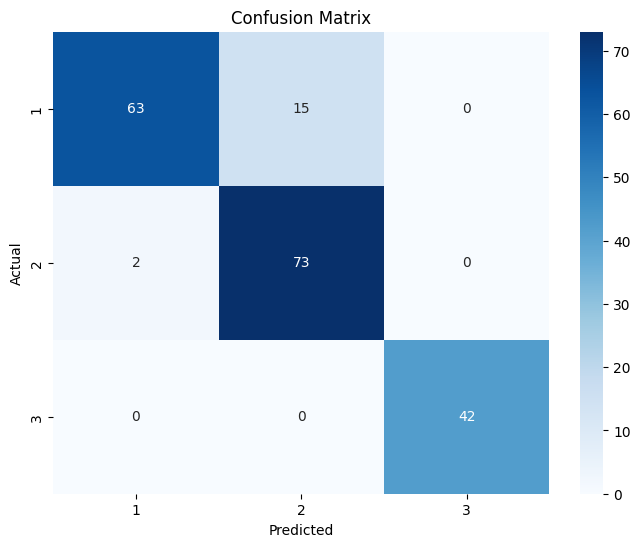

In [38]:
y_pred = final_model.predict(X_test)

get_results(y_test, y_pred, target_names)

In [39]:
df_times.to_csv('randsearch_times_rf.csv')